<a href="https://colab.research.google.com/github/hsleecri/XAI-for-anomaly-detection/blob/main/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***import packages and data***

In [ ]:
# import packages
!pip install optuna
!pip install xgboost
!pip install shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import confusion_matrix, f1_score
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets, ensemble, model_selection
import shap
from sklearn.datasets import make_multilabel_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [ ]:
#코랩으로 캐글 api 가져오기
!pip install kaggle
!mkdir ~/.kaggle
!echo '{"username":"hsleecri","key":"cd800a6117aa72a7070c5d23f02d4fa4"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#파일 디렉토리 설정
!mkdir data
%cd data

/content/data/data/data


In [ ]:
#분석 대상 데이터 다운
!kaggle datasets download -d subham07/detecting-anomalies-in-water-manufacturing

100% 122k/122k [00:00<00:00, 584kB/s]
100% 122k/122k [00:00<00:00, 583kB/s]


In [ ]:
#압축 해제
!unzip detecting-anomalies-in-water-manufacturing.zip

Archive:  detecting-anomalies-in-water-manufacturing.zip
  inflating: Test.csv                
  inflating: Train.csv               


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 읽기
data = pd.read_csv("Train.csv")

# ***EDA***

In [ ]:
# Exploratory Data Analysis (EDA)
print(data.info())  # Basic information about the data
print("Data sample:\n")
print(data.head())  # Display the first few rows of the data
print("\nData size:")
print(data.shape)  # Print the number of rows and columns
print("\nVariable types:")
print(data.dtypes)  # Print the data types of each variable
print("\nDescriptive statistics:")
print(data.describe())  # Descriptive statistics of numeric variables
print("\nMissing values:")
print(data.isnull().sum())  # Count the missing values in each variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Columns: 1559 entries, feature_1 to Class
dtypes: float64(1), int64(1558)
memory usage: 21.0 MB
None
Data sample:

   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0        100        160     1.6000          0          0          0   
1         20         83     4.1500          1          0          0   
2         99        150     1.5151          1          0          0   
3         40         40     1.0000          0          0          0   
4         12        234    19.5000          1          0          0   

   feature_7  feature_8  feature_9  feature_10  ...  feature_1550  \
0          0          0          0           0  ...             0   
1          0          0          0           1  ...             0   
2          0          0          0           0  ...             0   
3          0          0          0           0  ...             0   
4          0          0          0     

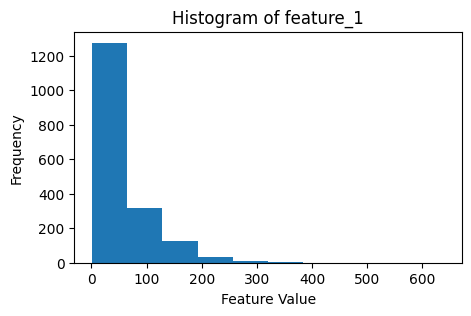

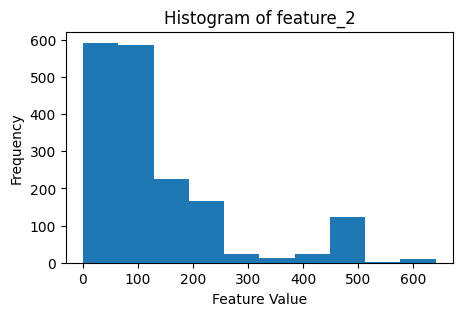

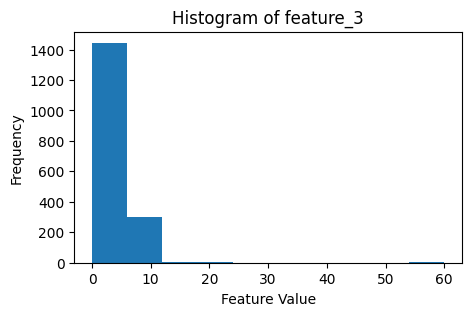

In [ ]:
# Create histograms for selected features
selected_features = ['feature_1', 'feature_2', 'feature_3']
for feature in selected_features:
    plt.figure(figsize=(5, 3))
    plt.hist(data[feature], bins=10)
    plt.xlabel("Feature Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {feature}")
    plt.show()

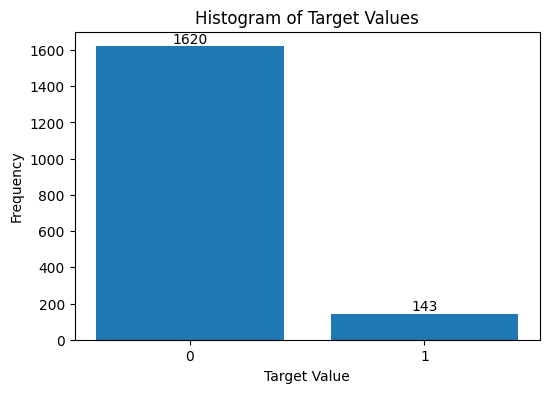

In [ ]:
# Count the values of the binary target variable
target_counts = data["Class"].value_counts()

# Plot the histogram of the target variable
plt.figure(figsize=(6, 4))
plt.bar(target_counts.index, target_counts.values)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
for i, count in enumerate(target_counts.values):
    plt.text(target_counts.index[i], count, str(count), ha='center', va='bottom')
plt.xticks(target_counts.index, rotation='horizontal')
plt.show()

# ***Pre-process the data***

excludes features with zero variance and scale non-binary numerical features

In [ ]:
# Separate the input features (X) and the target variable (y)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Find features with zero variance
zero_var_features = X.columns[X.var() == 0]
num_zero_var_features = len(zero_var_features)

# Exclude features with zero variance
X = X.drop(zero_var_features, axis=1)

# Print features with zero variance
print("Features with zero variance:")
print(zero_var_features)
print("Number of features with zero variance:", num_zero_var_features)

Features with zero variance:
Index(['feature_57', 'feature_82', 'feature_106', 'feature_147', 'feature_262',
       'feature_278', 'feature_284', 'feature_320', 'feature_362',
       'feature_372', 'feature_383', 'feature_435', 'feature_439',
       'feature_488', 'feature_495', 'feature_522', 'feature_531',
       'feature_553', 'feature_578', 'feature_591', 'feature_630',
       'feature_631', 'feature_652', 'feature_894', 'feature_934',
       'feature_978', 'feature_1038', 'feature_1063', 'feature_1096',
       'feature_1185', 'feature_1211', 'feature_1243', 'feature_1247',
       'feature_1341', 'feature_1367', 'feature_1407'],
      dtype='object')
Number of features with zero variance: 36


In [ ]:
# Scale only feature_1, feature_2, and feature_3
# scaled_columns = ['feature_1', 'feature_2', 'feature_3']
# scaled_indices = [X.columns.get_loc(col) for col in scaled_columns]
# scaler = StandardScaler()
X_scaled = X.copy()
# X_scaled.iloc[:, scaled_indices] = scaler.fit_transform(X_scaled.iloc[:, scaled_indices])

select top k important features determined by a random forest classifier


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Train a random forest classifier on the scaled features
rf = RandomForestClassifier()
rf.fit(X_scaled, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Select top k important features
k = 5
selected_features = X.columns[sorted_indices[:k]]

# Subset the data with selected features
X_selected = X_scaled[selected_features]

# Print selected features and their importances
print("Selected features and importances:")
for feature, importance in zip(selected_features, feature_importances[sorted_indices[:k]]):
    print(feature, ":", importance)

# Convert X_selected to pandas DataFrame
X_selected = pd.DataFrame(X_selected, columns=selected_features)

# Print information about the selected DataFrame
print("Selected DataFrame shape:", X_selected.shape)
print("Selected DataFrame head:")
print(X_selected.head())

Selected features and importances:
feature_2 : 0.05764257376095639
feature_3 : 0.04589931308975921
feature_1 : 0.03266269456276545
feature_352 : 0.02195755095411424
feature_1400 : 0.020466662765032773
Selected DataFrame shape: (1763, 5)
Selected DataFrame head:
   feature_2  feature_3  feature_1  feature_352  feature_1400
0        160     1.6000        100            0             0
1         83     4.1500         20            1             0
2        150     1.5151         99            0             0
3         40     1.0000         40            0             0
4        234    19.5000         12            0             0


In [ ]:
# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1410, 5) (1410,)
Test set shape: (353, 5) (353,)


# ***fit an XGBoost model and optimize the hyperparameters using Optuna***

In [ ]:
# Fit an XGBoost model and optimize the hyperparameters using Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000,step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.4, 0.8),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 0.8),
        'gamma': trial.suggest_int('gamma', 0, 5),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 0.1, 20),
        'max_deltda_step': trial.suggest_int('max_delta_step', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        # 'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
        'booster': trial.suggest_categorical('booster', ['gbtree'])
    }

    model = xgb.XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    f1_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1')
    return f1_scores.mean()

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best trial and best parameters
best_trial = study.best_trial
best_params = best_trial.params
best_score = best_trial.value

print("Best F1 Score:", best_score)
print("Best Parameters:", best_params)

In [ ]:
# Visualize optimization history
optuna.visualization.plot_optimization_history(study)

In [ ]:
# Visualize parameter importances
optuna.visualization.plot_param_importances(study)

# ***evaluate on the test set and report matrics***

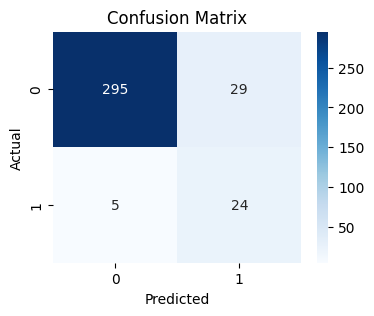

353


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

# Evaluate on the test set and report metrics
best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Create the confusion matrix
cm_test = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(len(X_test))

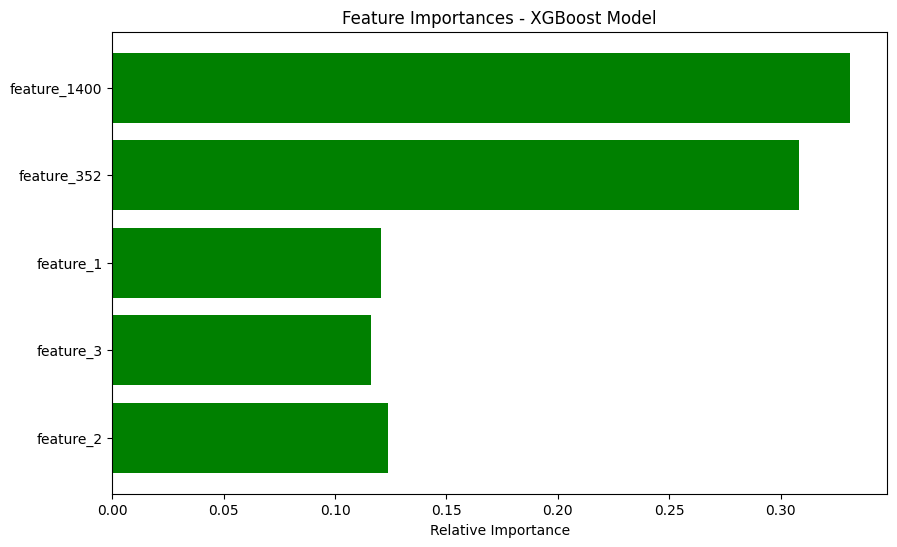

In [ ]:
# Get feature importances from the trained model
importances = best_model.feature_importances_
features = X_test.columns

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances, color='g', align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Relative Importance')
plt.title('Feature Importances - XGBoost Model')
plt.show()

# ***visualizes the fitted XGBoost model***

# ***The Entire dataset; X_test***

In [ ]:
# Import necessary libraries
import skimage
skimage.__version__

# Visualize the fitted XGBoost model using SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

In [ ]:
print(y_test.iloc[13])

0


In [ ]:
# 전체 검증 데이터 셋에 대해서 적용
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values, X_test)

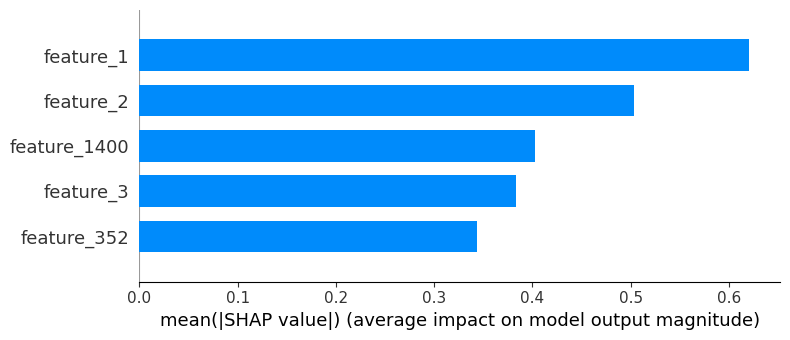

In [ ]:
# Plot summary
shap.summary_plot(shap_values, X_test.values, plot_type="bar", feature_names = X_test.columns)
# shap.summary_plot(shap_values, X_test.values, plot_type="bar", class_names= [y_test], feature_names = X_test.columns)

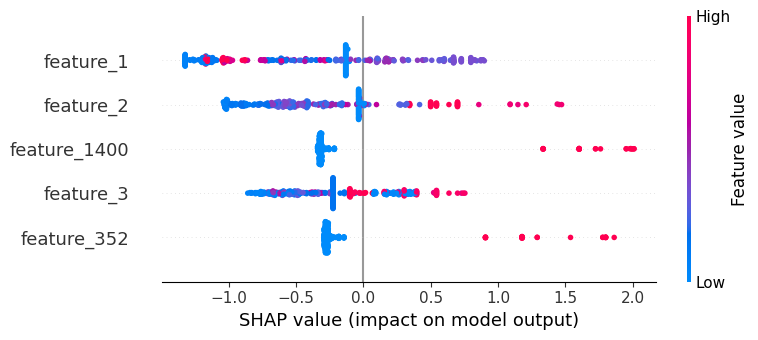

In [ ]:
# Plot the individual feature importance
shap.summary_plot(shap_values, X_test)
plt.show()

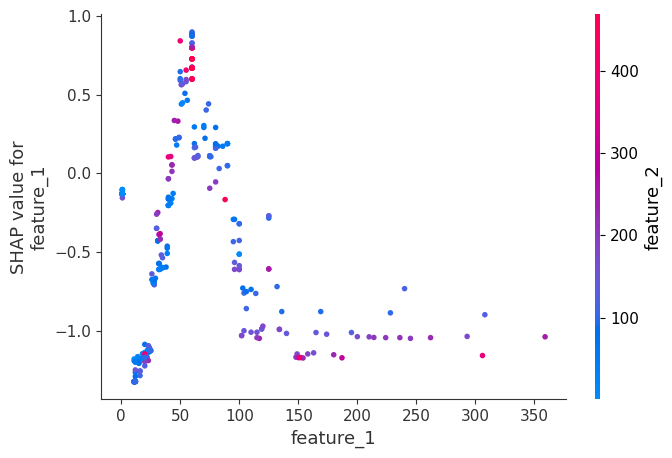

In [ ]:
# 변수 간의 shap value 파악
shap.dependence_plot("feature_1", shap_values, X_test)

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)
# 한 sample에 대해 SHAP 시각화
sample=61
print(y_test.iloc[sample])
shap.force_plot(explainer.expected_value, shap_values[sample,:], X_test.iloc[sample,:])

0


# ***FALSE NEGATIVES***

In [ ]:
# Compute false positives and false negatives
false_negatives = X_test[(y_pred == 0) & (y_test == 1)] #이게 중요한 친구
print(false_negatives.head())
print("The total number of false_negatives is", len(false_negatives))

shap_values_false_negatives = explainer.shap_values(false_negatives)

      feature_2  feature_3  feature_1  feature_352  feature_1400
891           1     2.0000          1            0             0
85          100     1.0000        100            0             0
1022        230     6.9696         33            0             0
818         200     6.6666         30            0             0
387         520     5.9090         88            0             0
The total number of false_negatives is 5


In [ ]:
# False Negatives
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values_false_negatives, false_negatives)

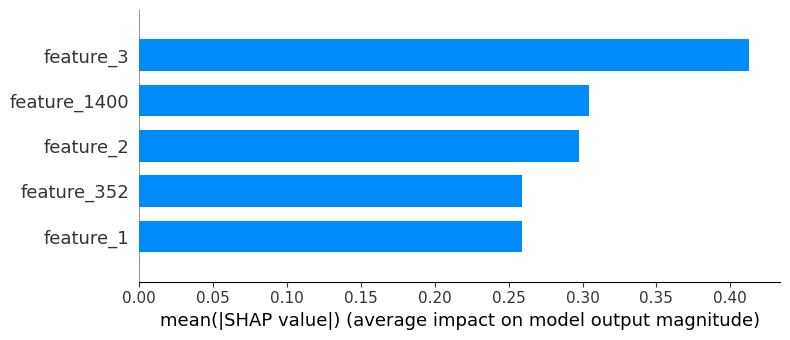

In [ ]:
# Plot
shap.summary_plot(shap_values_false_negatives, false_negatives, plot_type='bar')
plt.show()

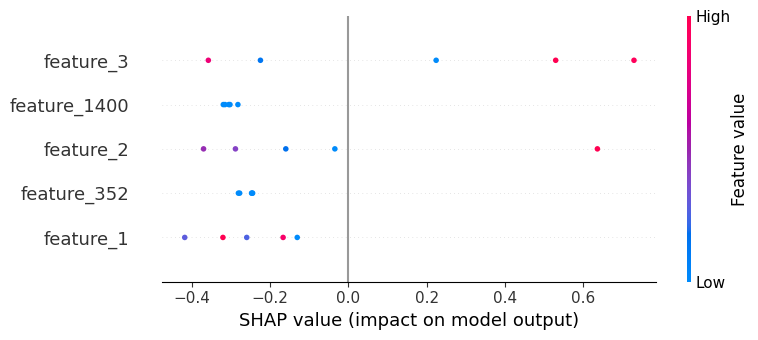

In [ ]:
# Plot the individual feature importance
shap.summary_plot(shap_values_false_negatives, false_negatives)
plt.show()

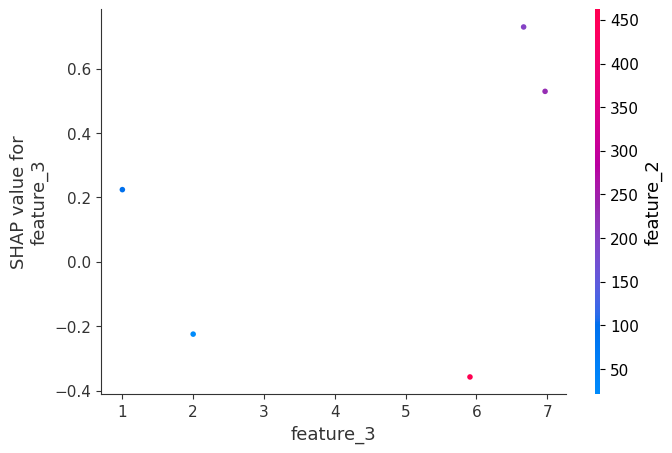

In [ ]:
# 변수 간의 shap value 파악
shap.dependence_plot("feature_3", shap_values_false_negatives, false_negatives)

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)
# 첫번째 에러에 대해 SHAP 시각화
sample=0
# shap.force_plot(explainer.expected_value, shap_values_false_negatives[0,:])
shap.force_plot(explainer.expected_value, shap_values_false_negatives[sample,:], false_negatives.iloc[sample,:])

# ***TRUE NEGATAIVES***

In [ ]:
# Compute true negatives
true_negatives = X_test[(y_pred == 1) & (y_test == 1)]
print(true_negatives.head())
print(len(true_negatives))

shap_values_true_negatives = explainer.shap_values(true_negatives)

      feature_2  feature_3  feature_1  feature_352  feature_1400
1740        120        2.0         60            0             1
599         468        7.8         60            1             1
689         468        7.8         60            0             0
355         468        7.8         60            0             0
1363        468        7.8         60            0             0
24


In [ ]:
# 전체 검증 데이터 셋에 대해서 적용
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values_true_negatives, true_negatives)

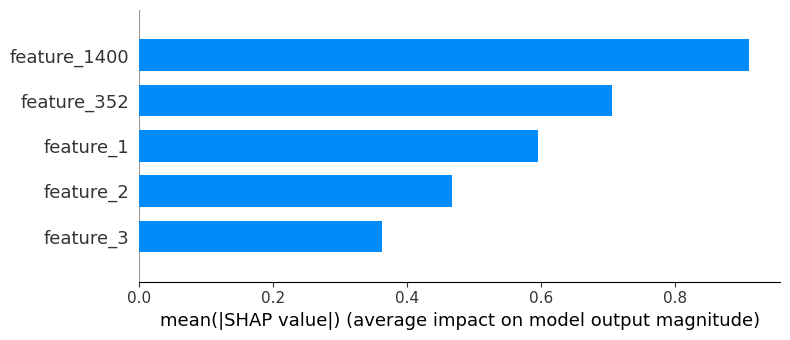

In [ ]:
# Plot
shap.summary_plot(shap_values_true_negatives, true_negatives, plot_type='bar')
plt.show()

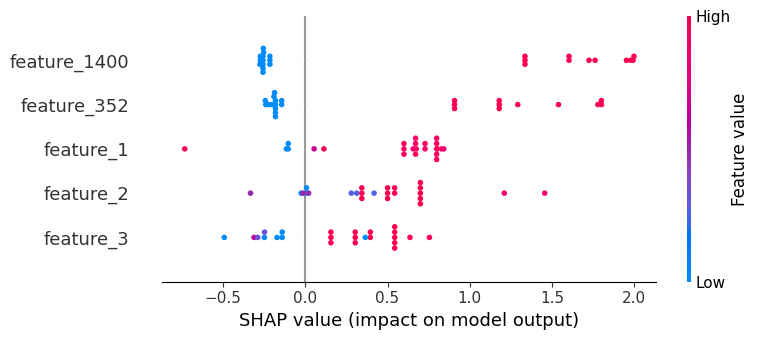

In [ ]:
# Plot the individual feature importance
shap.summary_plot(shap_values_true_negatives, true_negatives)
plt.show()

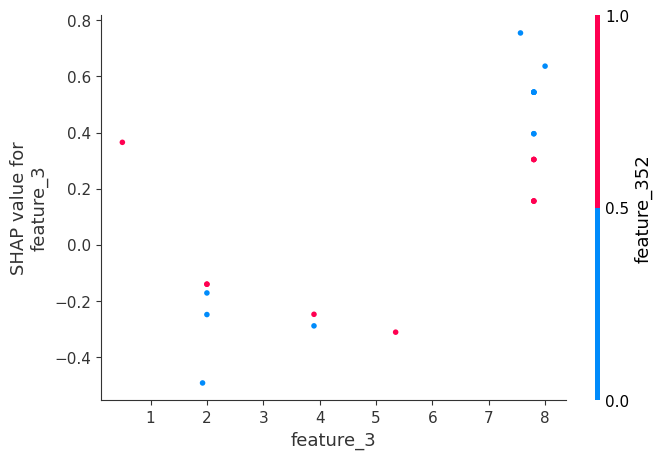

In [ ]:
# 변수 간의 shap value 파악
shap.dependence_plot("feature_3", shap_values_true_negatives, true_negatives)

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)
sample=6
shap.force_plot(explainer.expected_value, shap_values_true_negatives[sample,:], true_negatives.iloc[sample,:])